# Prepare 1000 Genome Reference dataset with full data
WARNING: NEEDS 60GB OF RAM

In [1]:
import allel
import h5py  # Python Package to do the HDF5.
import numpy as np
import pandas as pd
import socket
import os as os
import sys as sys
import multiprocessing as mp
import matplotlib.pyplot as plt

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)
#sys.path.append("./Python3/")  # Since now we are in the Root Directory

print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

sys.path.insert(0,"./package/")  # hack to get local package first in path
from hapsburg.PackagesSupport.h5_python.h5_functions import merge_in_ld_map, save_h5

midway2-0401.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


ImportError: cannot import name 'save_h5' from 'hapsburg.PackagesSupport.h5_python.h5_functions' (./package/hapsburg/PackagesSupport/h5_python/h5_functions.py)

### Helper Function

In [2]:
def vcf_to_hdf5(in_path, out_path, path_vcf100g=""):
    """Transform Full VCF to full HDF5"""
    allel.vcf_to_hdf5(input=in_path, output=out_path, compression="gzip") # Takes 10 Minutes ####chunk_length=1000000, chunk_width=1, garbage performance
    
def download_1kg(path_source="", path_target=""):
    """cluster: Whether program is run on cluster"""
    tbi_s = path_source + ".tbi"
    tbi_t = path_target + ".tbi"
    
    !scp $path_source $path_target # Only Download the .vcf (not the .tbi)
    !scp $tbi_s $tbi_t             # Download the tbi
    print(f"Transfer complete. To {path_target}")
    
def downsample_af(path_h5, path_save, maf=0.002, batch=1000000):
    """Loads hdf5 at path_h5, and filters to loci >maf.
    Save h5 at path_save. Assumes everything is in standard format"""

    f = h5py.File(path_h5, "r") # Load for Sanity Check. See below!

    ### Calculate the AFs
    k = np.shape(f["calldata/GT"])[0]
    
    idcs = [] # the list of list of idx in each batch
    ### Work in batches
    for i in range(int(k/batch)+1):
        print(f"Doing batch {i}...")
        gt = f["calldata/GT"][i*batch:(i+1)*batch,:,:]  
        n = np.shape(gt)[1]*2 # number of haplotypes
        gt = np.sum(gt==0, axis=1)
        gt = np.sum(gt, axis=1)
        p_der = 1 - gt/n
        idx = p_der > maf # Filter
        idcs.append(idx)
        
    idx = np.concatenate(idcs)
    print(f"Downsampling to {np.sum(idx)}/{len(idx)} Markers with MAF >{maf}")

    gt = f["calldata/GT"][:,:,:][idx] # Extract the Ind
    ref=f["variants/REF"][:][idx]
    alt=f["variants/ALT"][:][idx,0] # only save the first alt allele
    pos=f["variants/POS"][:][idx]
    rec=f["variants/MAP"][:][idx]
    samples=f["samples"][:]
    f.close()
    
    print("Saving new HDF...")
    save_h5(gt=gt, ad=[],
            ref=ref, alt=alt,
            pos=pos, rec=rec,
            samples=samples,
            path=path_save,
            compression='gzip',
            ad_group=False, gt_type='int8')

### Master Function

In [3]:
def full_prep_h5_full(ch = 4, maf=0.002):
    """Function to run the full preparation of HDF from 1000G VCF. 
    Comment out steps if not needed."""
    ### The Paths
    path_vcf_source = f"/project2/jnovembre/data/external_public/1kg_phase3/haps/ALL.chr{ch}.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz"
    path_vcf_here = f"./Data/1000Genomes/AutosomeVCF/Full/chr{ch}.vcf.gz"
    path_h5 = f"./Data/1000Genomes/HDF5/FULLHDF5/chr{ch}.hdf5"
    path_h5_maf = f"./Data/1000Genomes/HDF5/FULLHDF5/maf02_chr{ch}.hdf5"
    
    path_snp1240k = "./Data/1000Genomes/Markers/MinMyc.snp"
    
    ### The functions of the pipeline
    download_1kg(path_vcf_source, path_vcf_here)  ## Takes about 20 seconds
    vcf_to_hdf5(path_vcf_here, path_h5)            ## Takes about 20 minutes
    merge_in_ld_map(path_h5=path_h5, path_snp1240k=path_snp1240k, chs=[ch,], write_mode="a")  ## Takes about XX seconds, mode a for new LD Map
    downsample_af(path_h5, path_h5_maf, maf=maf)
    
    print(f"Run Finished Successfully!")

# Do the full Run

In [5]:
%%time
for ch in range(1,3):
    full_prep_h5_full(ch = ch)

Transfer complete. To ./Data/1000Genomes/AutosomeVCF/Full/chr1.vcf.gz
Lifting LD Map from eigenstrat to HDF5...
Loaded 6468094 variants.
Loaded 2504 individuals.
Loaded 93166 Chr.1 1240K SNPs.
Intersection 89658 out of 6468094 HDF5 SNPs
Interpolating 6378436 variants.
Finished Chromosome 1.
Adding map to HDF5...
We did it. Finished.
Doing batch 0...
Doing batch 1...
Doing batch 2...
Doing batch 3...
Doing batch 4...
Doing batch 5...
Doing batch 6...
Downsampling to 1840756/6468094 Markers with MAF >0.002
Saving new HDF...
Successfully saved 2504 individuals to: ./Data/1000Genomes/HDF5/FULLHDF5/maf02_chr1.hdf5
Run Finished Successfully!
Transfer complete. To ./Data/1000Genomes/AutosomeVCF/Full/chr2.vcf.gz
Lifting LD Map from eigenstrat to HDF5...
Loaded 7081600 variants.
Loaded 2504 individuals.
Loaded 98657 Chr.2 1240K SNPs.
Intersection 94812 out of 7081600 HDF5 SNPs
Interpolating 6986788 variants.
Finished Chromosome 2.
Adding map to HDF5...
We did it. Finished.
Doing batch 0...
Doin

### Downsample to AF SNPs

# Area 51

In [2]:
### Test the Final HDF5 just created
ch = 3
path_load = f"./Simulated/1000G_Mosaic/TSI5/ch3_0cm/data.h5"

f = h5py.File(path_load, "r") # Load for Sanity Check. See below!
print("Loaded %i variants" % np.shape(f["calldata/GT"])[0])
print("Loaded %i individuals" % np.shape(f["calldata/GT"])[1])
print(list(f["calldata"].keys()))
print(list(f["variants"].keys()))

Loaded 77652 variants
Loaded 100 individuals
['AD', 'GT']
['ALT', 'MAP', 'POS', 'REF']


In [6]:
f["samples"][:].astype("str")=="iid0"

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

# Test loading the new hdf5 file

In [6]:
### Test the Final HDF5 just created
ch = 4
path_load = f"./Data/1000Genomes/HDF5/FULLHDF5/maf02_chr{ch}.hdf5"

f = h5py.File(path_load, "r") # Load for Sanity Check. See below!
print("Loaded %i variants" % np.shape(f["calldata/GT"])[0])
print("Loaded %i individuals" % np.shape(f["calldata/GT"])[1])
print(list(f["calldata"].keys()))
print(list(f["variants"].keys()))

Loaded 1690781 variants
Loaded 2504 individuals
['GT']
['ALT', 'MAP', 'POS', 'REF']


In [7]:
f.close()

# Do experiments about loading time of data

In [52]:
from time import time

In [ ]:
%%time
res = []
s = np.shape(f["calldata/GT"])
ts = [10,50,100,500,1000, 5000, 10000, 50000, 100000]

for i in ts:
    print(f"Doing {i} Loci")
    t = time() 
    idx = np.random.choice(s[0], size=i, replace=False)
    idx=  np.sort(idx)
    gt = f["calldata/GT"][idx,:,:]
    e = time()
    res.append(e-t)

# Allele Frequency Spectrum

In [ ]:
%%time
gt = f["calldata/GT"][:,:,:]
gt1 = np.sum(gt==0, axis=1)
gt2 = np.sum(gt1, axis=1)
p_der = 1 - gt2/(np.shape(gt)[1]*2)

In [ ]:
np.mean(p_der < 0.002)

In [21]:
f.close()

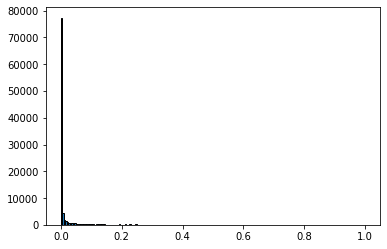

In [12]:
bins = np.linspace(0,1,201)

plt.figure()
ax = plt.gca()
ax.hist(p_der, ec="k", bins=bins)
plt.show()

In [15]:
np.mean(p_der < 0.002)

0.69748

In [45]:
f.close()

### Plot the runtime curve for loading time of #random SNPs

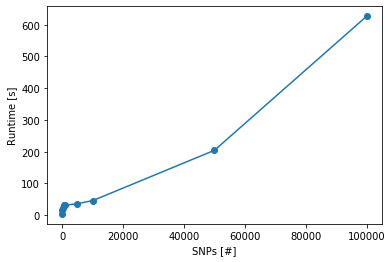

In [65]:
plt.figure()
ax = plt.gca()
ax.plot(ts, res, "o-")
ax.set_xlabel("SNPs [#]")
ax.set_ylabel("Runtime [s]")
plt.show()

In [38]:
gt = f["calldata/GT"][idx,:,:]

(100, 2504, 2)

In [72]:
%%time
gt = f["calldata/GT"][:,:,:]

CPU times: user 1min 2s, sys: 13.1 s, total: 1min 15s
Wall time: 1min 15s


In [10]:
gt[0].dtype

dtype('int8')

In [ ]:
print(f"Doing {i} Loci")

In [2]:
import psutil
print(psutil.virtual_memory().used / (1024.0 ** 3))
print(psutil.virtual_memory().total / (1024.0 ** 3))

5.535064697265625
62.49126052856445


### Try loading 1e6 genotypes - check how much data is needed

In [8]:
a = 1

In [9]:
print(psutil.virtual_memory().used / (1024.0 ** 3))
print(psutil.virtual_memory().total / (1024.0 ** 3))

5.534832000732422
62.49126052856445


In [8]:
%%time
gt = f["calldata/GT"][:1000000,:,1]

CPU times: user 19.1 s, sys: 1.26 s, total: 20.4 s
Wall time: 20.4 s


In [14]:
print(psutil.virtual_memory().used / (1024.0 ** 3))
print(psutil.virtual_memory().total / (1024.0 ** 3))

10.221786499023438
62.49126052856445


# The chunked HDF5 [Legacy because too slow]

In [17]:
### Test the Final HDF5 just created
ch = 4
path_load = f"./Data/1000Genomes/HDF5/FULLHDF5/chr{ch}_chunk.hdf5"

f = h5py.File(path_load, "r") # Load for Sanity Check. See below!
print("Loaded %i variants" % np.shape(f["calldata/GT"])[0])
print("Loaded %i individuals" % np.shape(f["calldata/GT"])[1])
print(list(f["calldata"].keys()))
print(list(f["variants"].keys()))

Loaded 5732585 variants
Loaded 2504 individuals
['GT']
['ALT', 'CHROM', 'FILTER_PASS', 'ID', 'MAP', 'POS', 'QUAL', 'REF']


# Test Imputed Genetic Map

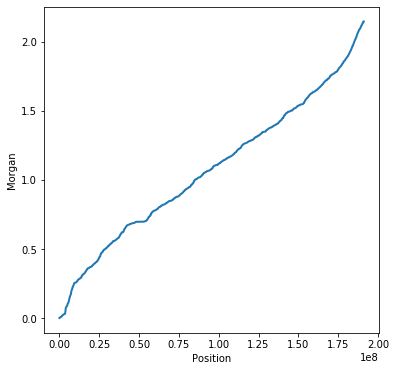

In [14]:
plt.figure(figsize=(6,6))
ax = plt.gca()

ax.plot(f["variants/POS"][:], f["variants/MAP"][:], lw=2)
ax.set_xlabel("Position")
ax.set_ylabel("Morgan")
plt.show()

In [10]:
np.shape(f["calldata/GT"])

(5732585, 2504, 2)

In [7]:
f["calldata/GT"][:100,0,0].

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int8)

In [11]:
f.close()

## Sandbox

In [ ]:
### Code to change hdf5 gt to int9
%%time

out_folder = "./Data/1000Genomes/HDF5/1240kHDF5/all1240bool0/chr"

def create_int_h5(org_folder = "./Data/1000Genomes/HDF5/FULLHDF5/chr",
                  out_folder = "./Data/1000Genomes/HDF5/FULLHDF5.int8/chr",
                  ch=4):
    """Create a int8 genotype hdf5 from full hdf5"""
    load_path = org_folder + str(ch) + ".h5"
    save_path = out_folder + str(ch) + ".h5" 

    # Make Directory if not already there
    if not os.path.exists(os.path.dirname(save_path)):   
        os.makedirs(os.path.dirname(save_path))

    #os.remove(save_path)  # For previous whoopsie
    m = ModifyHDF5Genotypes(original_path=load_path, save_path=save_path)
    m.downsample_gt(frac=1.0, ad=False, mult_alt=True, gt_type="int8")